In [ ]:
!pip install torch 
!pip install fastai --upgrade
!pip install opencv-python
!pip install numpy
!pip install natsort
!pip install piqa

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r /content/drive/MyDrive/Dane/Dataset_DB_Furniture.zip /content/   
!unzip Dataset_DB_Furniture.zip

In [4]:
import os
dataset_path = '/content/Dataset_DB_Furniture/'
dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_valid = os.path.join(dataset_path, 'valid')
dataset_path_test = os.path.join(dataset_path, 'test')

In [5]:
import torch
from torch.utils.data import Dataset
import cv2 as cv
from natsort import natsorted
import numpy as np
import os


def tensor_from_1ch_image(image: np.array) -> torch.Tensor:
    return torch.from_numpy(image).unsqueeze(dim=0)


def tensor_from_nch_image(image: np.array) -> torch.Tensor:
    return torch.from_numpy(image).permute(2, 0, 1)


def image_from_tensor(tensor: torch.Tensor, div: float = 255.0, scale = True) -> np.ndarray:
    img = tensor.permute(1, 2, 0).numpy()
    if scale:
      img = img * div
    return img.astype(np.float32)


class RotationDataset(Dataset):
    def __init__(self, dataset_path, depth_div, greyscale=False, transform=None):
        self.transform = transform
        self.dataset_path = dataset_path
        self.inputs_path = os.path.join(self.dataset_path, 'inputs')
        self.targets_path = os.path.join(self.dataset_path, 'targets')
        self.inputs = natsorted(os.listdir(self.inputs_path))
        self.targets = natsorted(os.listdir(self.targets_path))
        self.depth_div = depth_div
        self.rgb_div = 255.0
        self.greyscale = greyscale

    def __getitem__(self, index):
        input_path, target_path = os.path.join(self.inputs_path, self.inputs[index]), \
                                  os.path.join(self.targets_path, self.targets[index])

        input_img, target_img = np.load(input_path).astype(np.float32), \
                                np.load(target_path).astype(np.float32) / self.depth_div
        input_rgb = input_img[:, :, 0:3]/self.rgb_div
        input_grey = cv.cvtColor(input_rgb, cv.COLOR_RGB2GRAY)
        input_depth = input_img[:, :, 3:] / self.depth_div
        input_rgb_tensor = tensor_from_nch_image(input_rgb)
        input_depth_tensor = tensor_from_1ch_image(input_depth) if len(input_depth.shape) == 2 else tensor_from_nch_image(input_depth)
        target_depth_tensor = tensor_from_1ch_image(target_img)
        if self.greyscale:
            input_grey_tensor = tensor_from_1ch_image(input_grey)
            input_tensor = torch.cat((input_depth_tensor, input_grey_tensor), dim=0)
        else:
            input_tensor = torch.cat((input_rgb_tensor, input_depth_tensor), dim=0)
        return input_tensor, target_depth_tensor

    def __len__(self):
        return len(self.inputs)

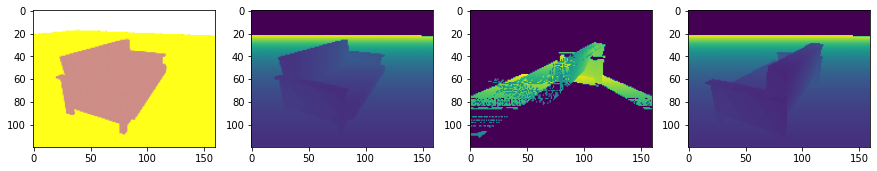

In [8]:
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt

def get_max_depth_value(path: str):
    _, depth_inputs, depth_targets, _ = get_rgbdp_paths(path)
    all_depth_inputs = depth_inputs + depth_targets
    return np.max([np.max(cv.imread(depth_img_path, flags=cv.IMREAD_ANYDEPTH)) for depth_img_path in all_depth_inputs])

# max_depth_value = 30562
max_depth_value = 39999
training_dataset = RotationDataset(dataset_path=dataset_path_train, depth_div=max_depth_value, transform=None)
training_dataloader = DataLoader(dataset=training_dataset, batch_size=1, shuffle=True)
input_tensor, target_depth = next(iter(training_dataloader))
input_tensor, target_depth = input_tensor[0], target_depth[0]
input_image = image_from_tensor(input_tensor, scale=False)
input_rgb, input_depth, projected_depth, target_depth = input_image[..., :3] * 255.0, \
                                                        input_image[..., 3] * max_depth_value,\
                                                        input_image[..., 4] * max_depth_value,\
                                                        image_from_tensor(target_depth, max_depth_value)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 15))
ax1.imshow(input_rgb.astype(np.uint8))
ax2.imshow(input_depth)
ax3.imshow(projected_depth)
ax4.imshow(target_depth.squeeze())



In [9]:
import torch
from typing import List
from piqa import ssim
def list_mean(values: List) -> float:
    return sum(values) / len(values)

class Train:
    def __init__(self,
                 device,
                 model,
                 criterion,
                 epochs,
                 learning_rate,
                 save_path,
                 training_dataset,
                 training_loader,
                 batch_size,
                 with_validation=False,
                 valid_dataset=None,
                 valid_loader=None):

        self.device = device
        self.model = model
        self.criterion = criterion
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.save_path = save_path
        self.training_dataset = training_dataset
        self.training_loader = training_loader
        self.valid_dataset = valid_dataset
        self.valid_loader = valid_loader

        self.model = self.model.to(self.device)
        self.criterion = self.criterion.to(self.device)
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate, weight_decay=1e-5)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(self.optimizer, 
                                                        mode='min',
                                                        factor=0.5, 
                                                        patience=10, 
                                                        threshold=0.01, 
                                                        threshold_mode='abs',
                                                        verbose=True)
        for epoch in range(self.epochs):
            training_losses = []
            validation_losses = []
            self.model.train()
            for i, (input_tensor, target_depth) in enumerate(self.training_loader):
                print(f'Epoch {epoch}, batch number: {i}/{len(self.training_dataset.inputs) // batch_size}')
                self.optimizer.zero_grad()
                input_tensor, target_depth = input_tensor.to(self.device), \
                                             target_depth.to(self.device)
                output_depth = model(input_tensor)
                if isinstance(self.criterion, ssim.MS_SSIM) or isinstance(self.criterion, ssim.SSIM): 
                  loss = 1 - self.criterion(torch.abs(output_depth), target_depth)
                else:
                  loss = self.criterion(output_depth, target_depth)
                loss.backward()
                self.optimizer.step()
                training_losses.append(loss.item())
            print(f'Average training loss:, {list_mean(training_losses)}')

            if with_validation:
                self.model.eval()
                with torch.no_grad():
                    for j, (input_tensor_valid, target_depth_valid) in enumerate(self.valid_loader):
                        input_tensor_valid, target_depth_valid = input_tensor_valid.to(self.device), \
                                                                 target_depth_valid.to(self.device)
                        output_depth_valid = self.model(input_tensor_valid)
                        if isinstance(self.criterion, ssim.MS_SSIM) or isinstance(self.criterion, ssim.SSIM): 
                          val_loss = 1 - self.criterion(torch.abs(output_depth_valid), target_depth_valid)
                        else:
                          val_loss = self.criterion(output_depth_valid, target_depth_valid)
                        validation_losses.append(val_loss.item())
                    print(f'Average validation loss:, {list_mean(validation_losses)}')
                scheduler.step(val_loss)
            if epoch % 5 == 0 and epoch != 0:
              torch.save(self.model, self.save_path)
        torch.save(self.model, self.save_path)

In [ ]:
# Train
from torch.utils.data import DataLoader
from fastai.vision.learner import create_unet_model
from fastai.vision import models
from torch import nn

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
encoder_model = models.resnet34
model = create_unet_model(encoder_model, n_out=1, img_size=(96, 128), n_in=5)
# model = torch.load('/content/drive/MyDrive/Models/01062021/UNet_DatasetDB_Furniture.pth')
criterion = nn.L1Loss()
# criterion = ssim.SSIM(n_channels = 1, window_size=4)
save_path = '/content/drive/MyDrive/Models/01062021/UNet_DatasetDB_Furniture.pth'
epochs = 50
learning_rate = 1e-3
batch_size = 32
training_dataset = RotationDataset(dataset_path=dataset_path_train, depth_div=max_depth_value, transform=None)
training_dataloader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
valid_dataset = RotationDataset(dataset_path=dataset_path_valid, depth_div=max_depth_value, transform=None)
valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)
Train(device, model, criterion, epochs, learning_rate, save_path, training_dataset, training_dataloader, batch_size, with_validation=True, valid_dataset=valid_dataset, valid_loader=valid_dataloader)

In [ ]:
test_dataset_path = '/content/Dataset_DB_10C_10IN/'
dataset_path_test = os.path.join(test_dataset_path, 'test')

In [11]:
# Validate
from torch import nn
from torch.utils.data import DataLoader
model_path = '/content/drive/MyDrive/Models/01062021/UNet_DatasetDB_Furniture.pth'
model = torch.load(model_path).cuda()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
criterion = nn.L1Loss().cuda()
save_name = os.path.basename(model_path)[:-4]
save_path = os.path.join('/content/', save_name)+'_Test'
if not os.path.exists(save_path):
  os.mkdir(save_path)
model.eval()
test_dataset = RotationDataset(dataset_path=dataset_path_test, depth_div=max_depth_value, transform=None)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)  
test_losses = []
for i, (input_tensor, target_depth) in enumerate(test_dataloader):
  input_tensor, target_depth = input_tensor.to(device), target_depth.to(device)
  output_depth = model(input_tensor)
  loss = criterion(output_depth, target_depth)
  test_losses.append(loss.item())
  input_image = image_from_tensor(input_tensor[0].detach().cpu(), scale=False)
  target_depth = target_depth[0].detach().cpu()
  output_depth = output_depth[0].detach().cpu()
  input_rgb, input_depth, projected_depth, target_depth = input_image[..., :3] * 255.0, input_image[..., 3] * max_depth_value, input_image[..., 4] * max_depth_value, image_from_tensor(target_depth, max_depth_value)
  output_depth = image_from_tensor(output_depth, max_depth_value)
  cv.imwrite(os.path.join(save_path, 'input_rgb'+str(i)+'.png'), input_rgb.astype(np.uint8))
  cv.imwrite(os.path.join(save_path, 'input_depth'+str(i)+'.png'), input_depth.astype(np.uint16))
  cv.imwrite(os.path.join(save_path, 'projected_depth'+str(i)+'.png'), projected_depth.astype(np.uint16))
  cv.imwrite(os.path.join(save_path, 'target_depth'+str(i)+'.png'), target_depth.astype(np.uint16))
  cv.imwrite(os.path.join(save_path, 'output_depth'+str(i)+'.png'), output_depth.astype(np.uint16))
print(list_mean(test_losses))

0.0035869480607805156


In [13]:
!zip -r /content/UNet_DatasetDB_Furniture.zip /content/UNet_DatasetDB_Furniture_Test/

  adding: content/UNet_DatasetDB_Furniture_Test/ (stored 0%)
  adding: content/UNet_DatasetDB_Furniture_Test/input_depth389.png (deflated 3%)
  adding: content/UNet_DatasetDB_Furniture_Test/output_depth24.png (deflated 2%)
  adding: content/UNet_DatasetDB_Furniture_Test/input_depth26.png (deflated 3%)
  adding: content/UNet_DatasetDB_Furniture_Test/input_rgb45.png (deflated 18%)
  adding: content/UNet_DatasetDB_Furniture_Test/projected_depth18.png (deflated 5%)
  adding: content/UNet_DatasetDB_Furniture_Test/target_depth202.png (deflated 7%)
  adding: content/UNet_DatasetDB_Furniture_Test/input_rgb275.png (deflated 20%)
  adding: content/UNet_DatasetDB_Furniture_Test/input_depth138.png (deflated 7%)
  adding: content/UNet_DatasetDB_Furniture_Test/input_rgb449.png (deflated 24%)
  adding: content/UNet_DatasetDB_Furniture_Test/input_depth336.png (deflated 6%)
  adding: content/UNet_DatasetDB_Furniture_Test/input_rgb156.png (deflated 13%)
  adding: content/UNet_DatasetDB_Furniture_Test/in

In [ ]:
!rm -r /content/UNet_DatasetDB
!rm -r /content/UNet_DatasetDB.zip
